In [1]:
from functions import *

2024-11-26 15:43:16.225564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 15:43:16.246451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 15:43:16.252899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 15:43:16.269519: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 15:43:17.394616: W tensorflow/compiler/tf2

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import glob
import time
from datetime import datetime
from collections import Counter
from PIL import Image

# Visualize one experiment

In [3]:
model='baseline_CNN'
exp = 1
spl = 3

#### Experiment details

In [4]:
df=pd.read_excel(f'../official_results/{model}_results.xlsx')
df['Normalized Variables'] = df['Variables'].apply(
    lambda x: ', '.join(sorted(x.split(', '))))


In [5]:
# Define mapping for concise names
variable_set_mapping = {
    'lst': 'LST',
    'lst, ndvi': 'LST + NDVI',
    'altitude, direction, lst, ndvi, slope': 'All Image Features',
    'discharge, lat, lon, lst, month, ndvi': 'LST + NDVI + Non-image Features',
    'altitude, direction, discharge, lat, lon, lst, month, ndvi, slope': 'Full Features'
}

# Apply mapping
df['Normalized Variables'] = df['Normalized Variables'].map(variable_set_mapping)
df

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
0,1,5.683873,lst,74 cells,stratified,3,Adam,1487,32,57 of 300,2024-11-20,10:35:18,259.58,Physics-guided,8,LST
1,2,5.095058,lst,74 cells,stratified,3,Adam,1487,32,54 of 300,2024-11-20,10:39:12,232.63,RMSE,8,LST
2,3,5.064375,lst,74 cells,stratified,3,Adam,1487,64,102 of 300,2024-11-20,10:49:56,292.51,Physics-guided,8,LST
3,4,4.963711,lst,74 cells,stratified,3,Adam,1487,64,119 of 300,2024-11-20,10:55:22,323.51,RMSE,8,LST
4,3,5.005169,lst,74 cells,stratified,3,Adam,1487,128,74 of 300,2024-11-20,10:57:50,146.31,Physics-guided,8,LST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,100,4.998228,lst,74 cells + augmented,stratified,2,Adam,1487,64,85 of 300,2024-11-25,13:43:28,375.22,RMSE,64,LST
212,100,4.905393,lst,74 cells + augmented,stratified,3,Adam,1487,64,83 of 300,2024-11-25,13:49:57,386.69,RMSE,64,LST
213,214,4.884714,lst,74 cells + augmented,stratified,1,Adam,1487,128,300 of 300,2024-11-26,11:16:32,900.10,RMSE,64,LST
214,215,4.909993,lst,74 cells + augmented,stratified,2,Adam,1487,128,300 of 300,2024-11-26,11:31:30,895.51,RMSE,64,LST


In [6]:
df[df.RMSE == df['RMSE'].min()]

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
165,154,4.506993,"lst, ndvi, slope, direction, altitude, month, ...",74 cells,stratified,2,Adam,1487,128,67 of 300,2024-11-21,16:44:25,158.26,RMSE,64,Full Features


#### Learning curve

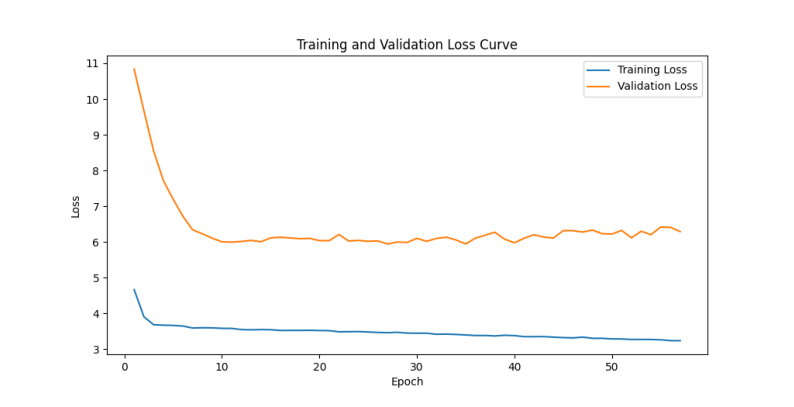

In [7]:
image_path = f'../official_results/learning_curves/{model}_exp_{exp}_split_{spl}.png'
image = Image.open(image_path)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


#### Error log

In [8]:
errors_df = pd.read_csv(f'../official_results/error_logs/{model}_exp_{exp}_split_{spl}.csv')

In [9]:
errors_df_filt = errors_df[errors_df['epoch'] <= 100]

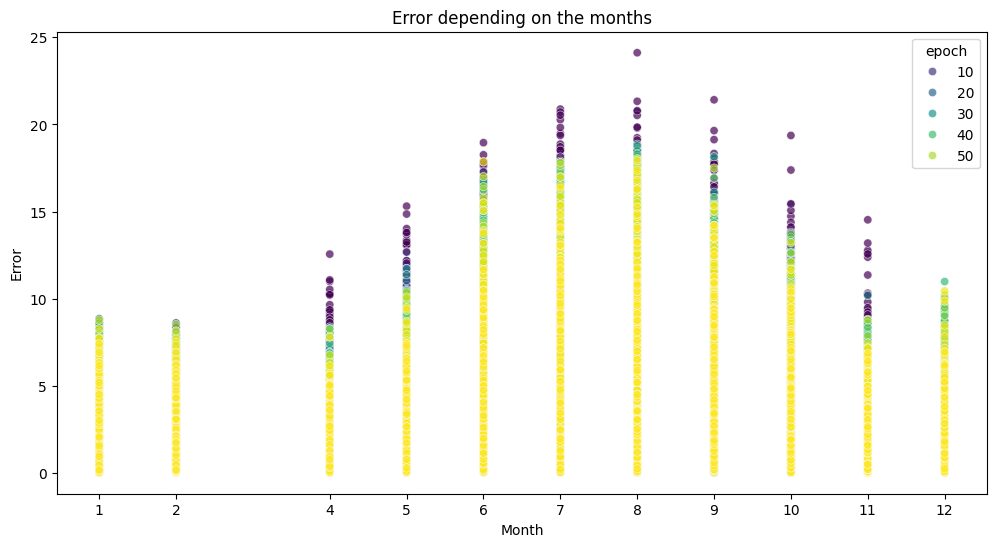

In [10]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=errors_df_filt, x="month", y="error", hue="epoch", palette="viridis", alpha=0.7)
plt.xticks(ticks=sorted(errors_df_filt["month"].unique()))
plt.title("Error depending on the months")
plt.xlabel("Month")
plt.ylabel('Error')
plt.show()

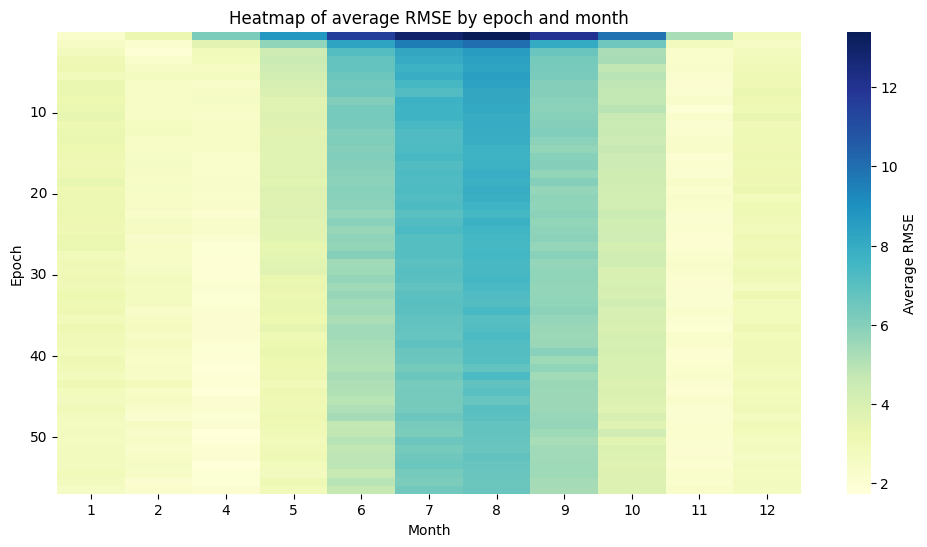

In [11]:
epochs = len(errors_df_filt.epoch.unique())
pivot_table = errors_df_filt.pivot_table(values="error", index="epoch", columns="month", aggfunc="mean")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", cbar_kws={'label': 'Average RMSE'})
if epochs == 10:
    ticks = range(epochs + 1)
    labelss = [str(i) for i in range(epochs + 1)]
else:
    ticks = [i for i in range(10, epochs + 1, 10)]
    labelss = [str(i) for i in range(10, epochs + 1, 10)]
plt.yticks(ticks=ticks,labels=labelss)
plt.title("Heatmap of average RMSE by epoch and month")
plt.xlabel("Month")
plt.ylabel("Epoch")
plt.savefig(f"../plots/season_learning_exp_{exp}_split_{spl}.png")
plt.show()

# Analysis of all baseline experiments

In [12]:
grouping_columns = [col for col in df.columns if col not in ['Date','Split_id', 'RMSE','Duration','Time','Experiment','Epochs','Variables']]

experiment_mean_rmse = df.groupby(grouping_columns)['RMSE'].mean().reset_index()
print('Best experiment combination:')
print(experiment_mean_rmse.loc[experiment_mean_rmse['RMSE'].idxmin()])
print('\nFull experiments combination:', len(experiment_mean_rmse))
experiment_mean_rmse.sort_values("RMSE").head(10)

Best experiment combination:
Input                        74 cells
Split                      stratified
Optimizer                        Adam
nº samples                       1487
Batch size                        128
Loss                             RMSE
Resolution                         64
Normalized Variables    Full Features
RMSE                          4.74799
Name: 65, dtype: object

Full experiments combination: 74


,Input,Split,Optimizer,nº samples,Batch size,Loss,Resolution,Normalized Variables,RMSE
65,74 cells,stratified,Adam,1487,128,RMSE,64,Full Features,4.747990
58,74 cells,stratified,Adam,1487,128,RMSE,16,LST + NDVI,4.797674
41,74 cells,stratified,Adam,1487,64,RMSE,64,All Image Features,4.812507
53,74 cells,stratified,Adam,1487,128,RMSE,8,LST + NDVI,4.856707
31,74 cells,stratified,Adam,1487,64,RMSE,16,All Image Features,4.858441
73,74 cells + augmented,stratified,Adam,1487,128,RMSE,64,LST,4.895053
61,74 cells,stratified,Adam,1487,128,RMSE,32,Full Features,4.897588
29,74 cells,stratified,Adam,1487,64,RMSE,8,LST + NDVI,4.905866
62,74 cells,stratified,Adam,1487,128,RMSE,32,LST,4.918594
69,74 cells,stratified,SGD,1487,128,RMSE,32,LST,4.924092


### RMSE for all experiments

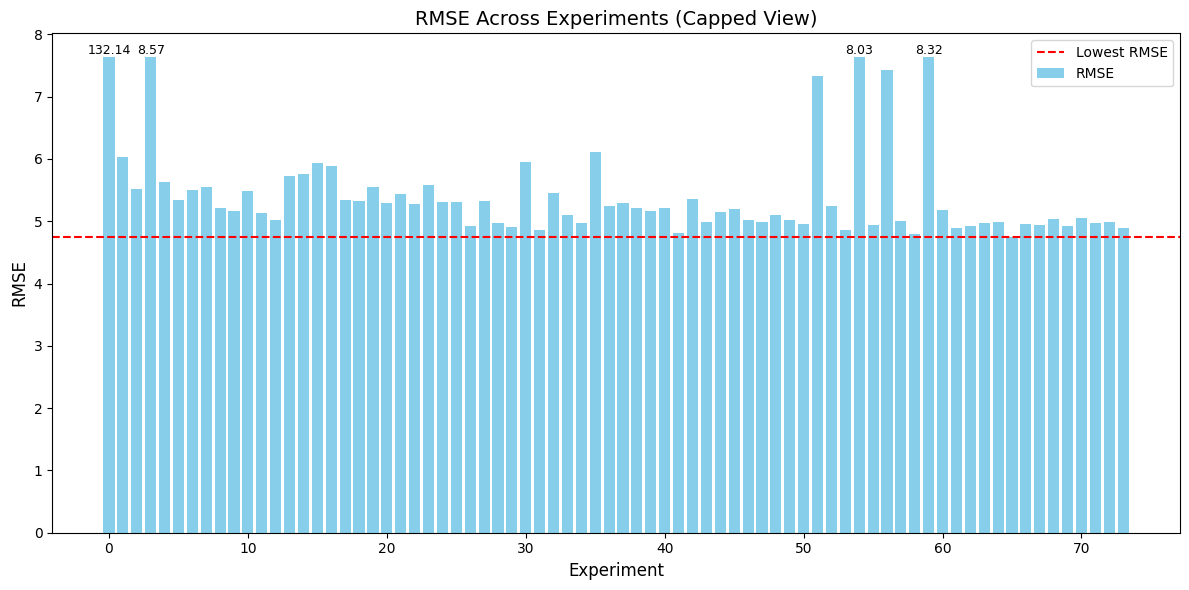

In [13]:
# Define a threshold for the highest bar
threshold = experiment_mean_rmse['RMSE'].quantile(0.95)  # Set to 95th percentile as an example

# Mark values exceeding the threshold
experiment_mean_rmse['Adjusted RMSE'] = experiment_mean_rmse['RMSE'].where(experiment_mean_rmse['RMSE'] <= threshold, threshold)

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(experiment_mean_rmse.index, experiment_mean_rmse['Adjusted RMSE'], color='skyblue', label="RMSE")
plt.axhline(y=experiment_mean_rmse['RMSE'].min(), color='red', linestyle='--', label="Lowest RMSE")

# Add text or markers for bars exceeding the threshold
for idx, row in experiment_mean_rmse.iterrows():
    if row['RMSE'] > threshold:
        plt.text(
            idx, threshold, f"{row['RMSE']:.2f}",
            ha='center', va='bottom', color='black', fontsize=9
        )

# Add labels, legend, and title
plt.xlabel('Experiment', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('RMSE Across Experiments (Capped View)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

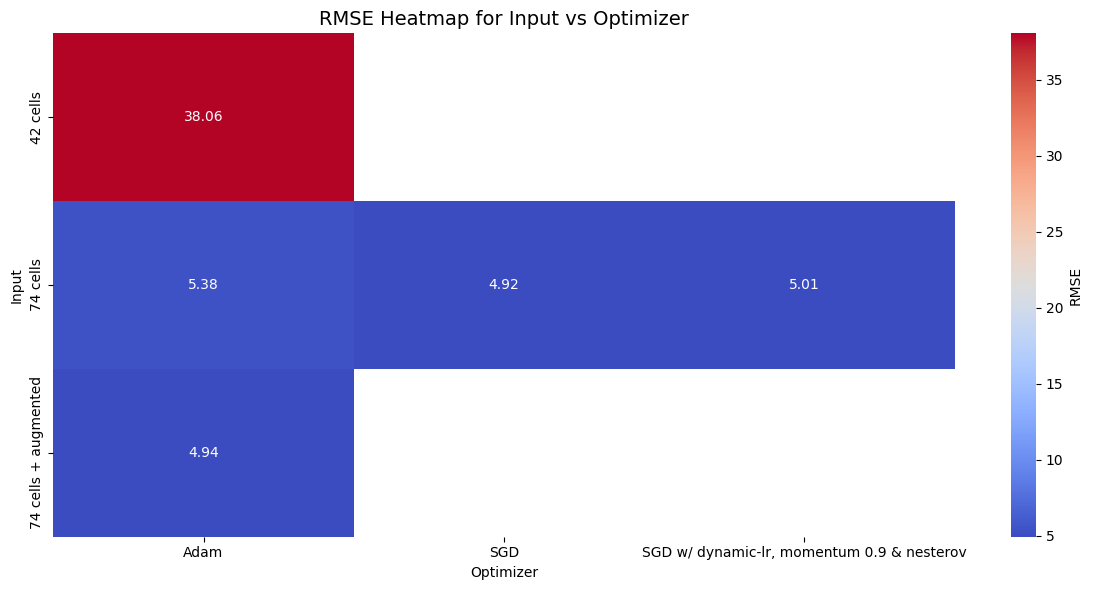

In [14]:
# Pivot table for a heatmap (you can adjust the rows and columns to focus on specific features)
heatmap_data = experiment_mean_rmse.pivot_table(
    index='Input', 
    columns='Optimizer', 
    values='RMSE', 
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'RMSE'})
plt.title("RMSE Heatmap for Input vs Optimizer", fontsize=14)
plt.xlabel("Optimizer")
plt.ylabel("Input")
plt.tight_layout()
plt.show()


# Training parameters experimentation

### Best combination (splits mean) w/lst

In [15]:
df_lst = df[df.Variables=='lst']
mean_rmse = df_lst.groupby(grouping_columns)["RMSE"].mean().reset_index()

# Identificar la combinación con el menor RMSE
best_combination = mean_rmse.loc[mean_rmse["RMSE"].idxmin()]
print(best_combination)
best_experiments = df_lst[
    (df["Resolution"] == best_combination["Resolution"]) &
    (df["Batch size"] == best_combination["Batch size"]) &
    (df["Loss"] == best_combination["Loss"])
]

# Mostrar todas las variables para estas filas
print("Best Experiments Details:")
best_experiments

Input                   74 cells + augmented
Split                             stratified
Optimizer                               Adam
nº samples                              1487
Batch size                               128
Loss                                    RMSE
Resolution                                64
Normalized Variables                     LST
RMSE                                4.895053
Name: 28, dtype: object
Best Experiments Details:


/tmp/ipykernel_2178488/131317256.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_experiments = df_lst[


,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
198,4,4.775533,lst,74 cells,stratified,1,Adam,1487,128,111 of 300,2024-11-19,15:31:48,233.60,RMSE,64,LST
207,7,5.102246,lst,74 cells,stratified,2,Adam,1487,128,138 of 300,2024-11-19,15:52:23,290.87,RMSE,64,LST
209,7,4.968356,lst,74 cells,stratified,3,Adam,1487,128,144 of 300,2024-11-19,15:58:21,284.47,RMSE,64,LST
213,214,4.884714,lst,74 cells + augmented,stratified,1,Adam,1487,128,300 of 300,2024-11-26,11:16:32,900.10,RMSE,64,LST
214,215,4.909993,lst,74 cells + augmented,stratified,2,Adam,1487,128,300 of 300,2024-11-26,11:31:30,895.51,RMSE,64,LST
215,216,4.890452,lst,74 cells + augmented,stratified,3,Adam,1487,128,300 of 300,2024-11-26,11:46:34,901.76,RMSE,64,LST


## Image resolution and batch size analysis

In [16]:
# Ordenar las combinaciones por RMSE promedio
mean_rmse_sorted = mean_rmse.sort_values("RMSE")

print("Top Combinations by Average RMSE:")
mean_rmse_sorted.head(10)  # Ver las 10 mejores combinaciones


Top Combinations by Average RMSE:


,Input,Split,Optimizer,nº samples,Batch size,Loss,Resolution,Normalized Variables,RMSE
28,74 cells + augmented,stratified,Adam,1487,128,RMSE,64,LST,4.895053
22,74 cells,stratified,Adam,1487,128,RMSE,32,LST,4.918594
24,74 cells,stratified,SGD,1487,128,RMSE,32,LST,4.924092
23,74 cells,stratified,Adam,1487,128,RMSE,64,LST,4.948712
12,74 cells,stratified,Adam,1487,64,RMSE,8,LST,4.967539
26,74 cells,stratified,"SGD w/ dynamic-lr, momentum 0.9 & nesterov",1487,128,RMSE,32,LST,4.972216
15,74 cells,stratified,Adam,1487,64,RMSE,64,LST,4.987893
27,74 cells + augmented,stratified,Adam,1487,64,RMSE,64,LST,4.988277
17,74 cells,stratified,Adam,1487,128,Physics-guided,16,LST,4.988699
21,74 cells,stratified,Adam,1487,128,RMSE,16,LST,4.996619


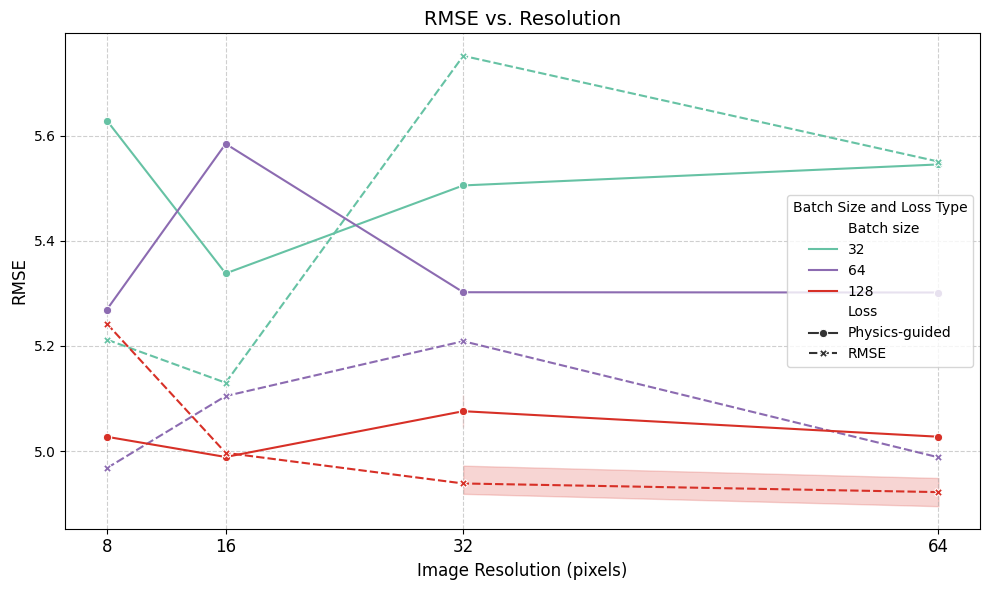

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

custom_palette = {
    32: "#66c2a4",  # Verde
    64: "#8c6bb1",  # Lila
    128: "#d73027"  # Rojo
}
# Crear un gráfico para los datos filtrados
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=mean_rmse,
    x="Resolution",
    y="RMSE",
    hue="Batch size",
    style="Loss",  # Diferenciar por tipo de Loss
    markers=True,
    palette=custom_palette  # Paleta de colores
)

resolutions_used = sorted(mean_rmse["Resolution"].unique())  # Obtener resoluciones únicas para este Split_id
plt.xticks(resolutions_used, labels=[str(res) for res in resolutions_used], fontsize=12)


# Configurar título y ejes
plt.title(f"RMSE vs. Resolution", fontsize=14)
plt.xlabel("Image Resolution (pixels)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.legend(title="Batch Size and Loss Type", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [18]:
mean_rmse[mean_rmse["Loss"] == "Physics-guided"]

,Input,Split,Optimizer,nº samples,Batch size,Loss,Resolution,Normalized Variables,RMSE
0,74 cells,stratified,Adam,1487,32,Physics-guided,8,LST,5.628922
1,74 cells,stratified,Adam,1487,32,Physics-guided,16,LST,5.337954
2,74 cells,stratified,Adam,1487,32,Physics-guided,32,LST,5.505405
3,74 cells,stratified,Adam,1487,32,Physics-guided,64,LST,5.545345
8,74 cells,stratified,Adam,1487,64,Physics-guided,8,LST,5.269224
9,74 cells,stratified,Adam,1487,64,Physics-guided,16,LST,5.584578
10,74 cells,stratified,Adam,1487,64,Physics-guided,32,LST,5.302179
11,74 cells,stratified,Adam,1487,64,Physics-guided,64,LST,5.301659
16,74 cells,stratified,Adam,1487,128,Physics-guided,8,LST,5.027155
17,74 cells,stratified,Adam,1487,128,Physics-guided,16,LST,4.988699


In [19]:
# Group and aggregate only RMSE
agg_rmse = mean_rmse[mean_rmse["Loss"] == "Physics-guided"].groupby(["Resolution", "Batch size"], as_index=False)["RMSE"].mean()
agg_rmse

,Resolution,Batch size,RMSE
0,8,32,5.628922
1,8,64,5.269224
2,8,128,5.027155
3,16,32,5.337954
4,16,64,5.584578
5,16,128,4.988699
6,32,32,5.505405
7,32,64,5.302179
8,32,128,5.075828
9,64,32,5.545345


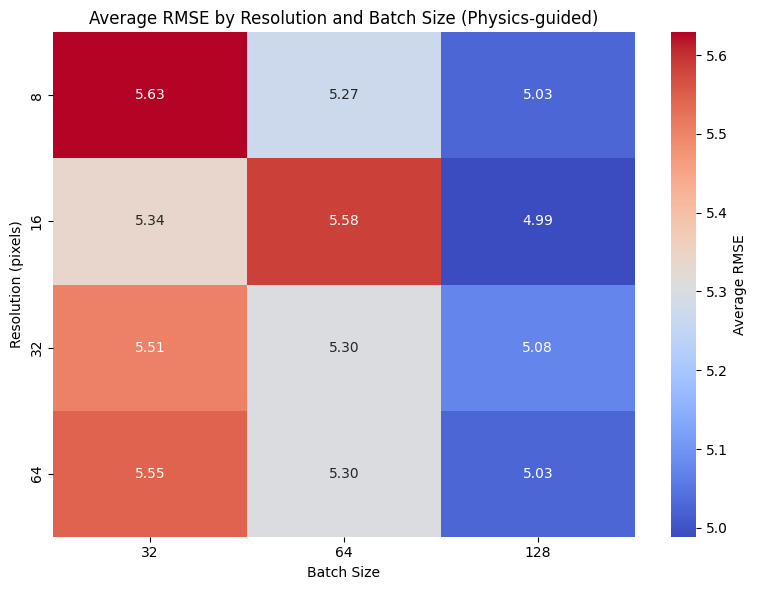

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar por tipo de Loss (por ejemplo, "Physics-guided")
physics_mean_rmse = agg_rmse.pivot(
    index="Resolution", columns="Batch size", values="RMSE"
)

plt.figure(figsize=(8, 6))
sns.heatmap(physics_mean_rmse, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Average RMSE'})
plt.title("Average RMSE by Resolution and Batch Size (Physics-guided)")
plt.xlabel("Batch Size")
plt.ylabel("Resolution (pixels)")
plt.tight_layout()
plt.show()


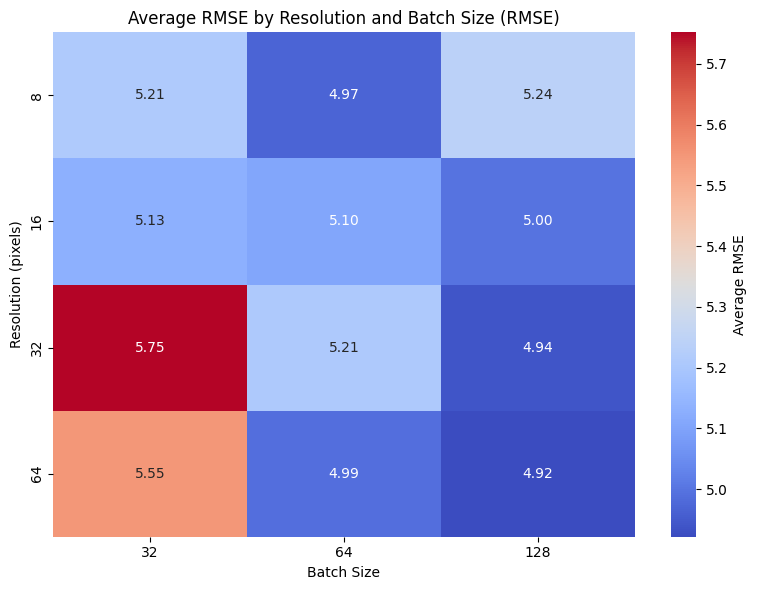

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar por tipo de Loss (por ejemplo, "Physics-guided")
agg_rmse = mean_rmse[mean_rmse["Loss"] == "RMSE"].groupby(["Resolution", "Batch size"], as_index=False)["RMSE"].mean()
physics_mean_rmse = agg_rmse.pivot(
    index="Resolution", columns="Batch size", values="RMSE"
)

plt.figure(figsize=(8, 6))
sns.heatmap(physics_mean_rmse, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Average RMSE'})
plt.title("Average RMSE by Resolution and Batch Size (RMSE)")
plt.xlabel("Batch Size")
plt.ylabel("Resolution (pixels)")
plt.tight_layout()
plt.show()


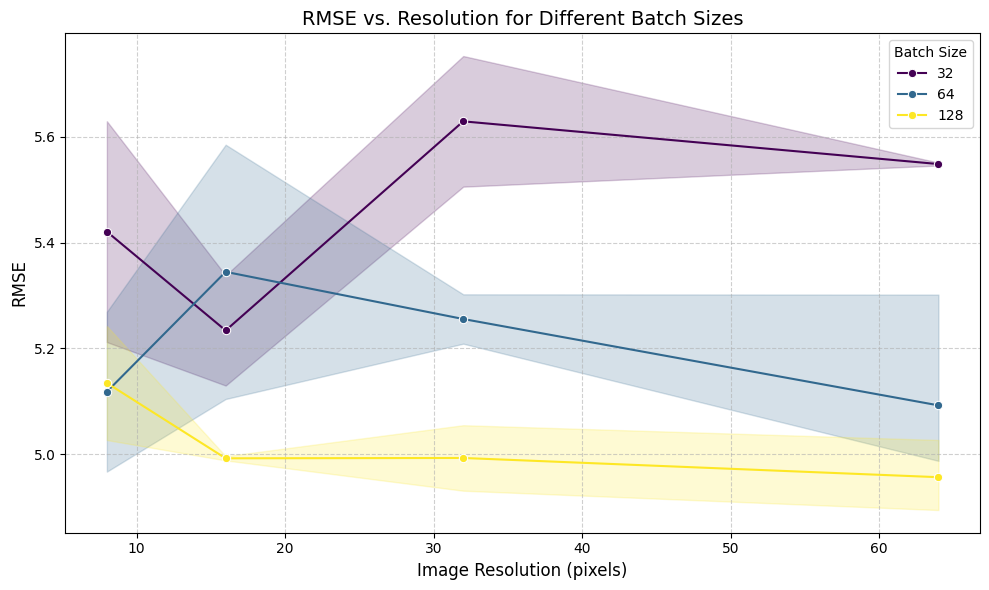

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de líneas para cada batch size
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_rmse, x="Resolution", y="RMSE", hue="Batch size", marker="o", palette="viridis")
plt.title("RMSE vs. Resolution for Different Batch Sizes", fontsize=14)
plt.xlabel("Image Resolution (pixels)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.legend(title="Batch Size", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Optimizer analysis

In [23]:
best_results = df_lst[(df_lst.Resolution==32)&(df['Batch size']==128)&(df['Loss']=='RMSE')]
best_results

/tmp/ipykernel_2178488/1765643091.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_results = df_lst[(df_lst.Resolution==32)&(df['Batch size']==128)&(df['Loss']=='RMSE')]


,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
17,14,4.870761,lst,74 cells,stratified,3,Adam,1487,128,124 of 300,2024-11-20,12:41:19,243.46,RMSE,32,LST
35,20,4.871874,lst,74 cells,stratified,1,Adam,1487,128,193 of 300,2024-11-20,13:59:44,378.09,RMSE,32,LST
36,37,4.885543,lst,74 cells,stratified,1,SGD,1487,128,111 of 300,2024-11-20,14:24:39,181.10,RMSE,32,LST
37,37,4.962777,lst,74 cells,stratified,2,SGD,1487,128,137 of 300,2024-11-20,14:26:24,218.26,RMSE,32,LST
38,39,4.923957,lst,74 cells,stratified,3,SGD,1487,128,109 of 300,2024-11-20,14:37:29,179.43,RMSE,32,LST
39,40,5.013146,lst,74 cells,stratified,2,Adam,1487,128,149 of 300,2024-11-20,14:49:25,300.96,RMSE,32,LST
42,43,4.972216,lst,74 cells,stratified,1,"SGD w/ dynamic-lr, momentum 0.9 & nesterov",1487,128,104 of 300,2024-11-20,15:22:32,178.70,RMSE,32,LST


In [24]:
rmse_mean = best_results.groupby('Optimizer')['RMSE'].mean().reset_index()

rmse_mean = rmse_mean.sort_values(by='RMSE')

print(rmse_mean)

                                    Optimizer      RMSE
0                                        Adam  4.918594
1                                         SGD  4.924092
2  SGD w/ dynamic-lr, momentum 0.9 & nesterov  4.972216


# Variables experimentation

In [25]:
df_vars = df[(df.Optimizer=='Adam')&(df.Loss=='RMSE')]
df_vars

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
1,2,5.095058,lst,74 cells,stratified,3,Adam,1487,32,54 of 300,2024-11-20,10:39:12,232.63,RMSE,8,LST
3,4,4.963711,lst,74 cells,stratified,3,Adam,1487,64,119 of 300,2024-11-20,10:55:22,323.51,RMSE,8,LST
5,4,5.699383,lst,74 cells,stratified,3,Adam,1487,128,61 of 300,2024-11-20,10:59:52,120.38,RMSE,8,LST
7,8,5.048740,lst,74 cells,stratified,3,Adam,1487,32,66 of 300,2024-11-20,11:28:42,284.93,RMSE,16,LST
9,8,5.082832,lst,74 cells,stratified,3,Adam,1487,64,98 of 300,2024-11-20,11:38:02,270.29,RMSE,16,LST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,100,4.998228,lst,74 cells + augmented,stratified,2,Adam,1487,64,85 of 300,2024-11-25,13:43:28,375.22,RMSE,64,LST
212,100,4.905393,lst,74 cells + augmented,stratified,3,Adam,1487,64,83 of 300,2024-11-25,13:49:57,386.69,RMSE,64,LST
213,214,4.884714,lst,74 cells + augmented,stratified,1,Adam,1487,128,300 of 300,2024-11-26,11:16:32,900.10,RMSE,64,LST
214,215,4.909993,lst,74 cells + augmented,stratified,2,Adam,1487,128,300 of 300,2024-11-26,11:31:30,895.51,RMSE,64,LST


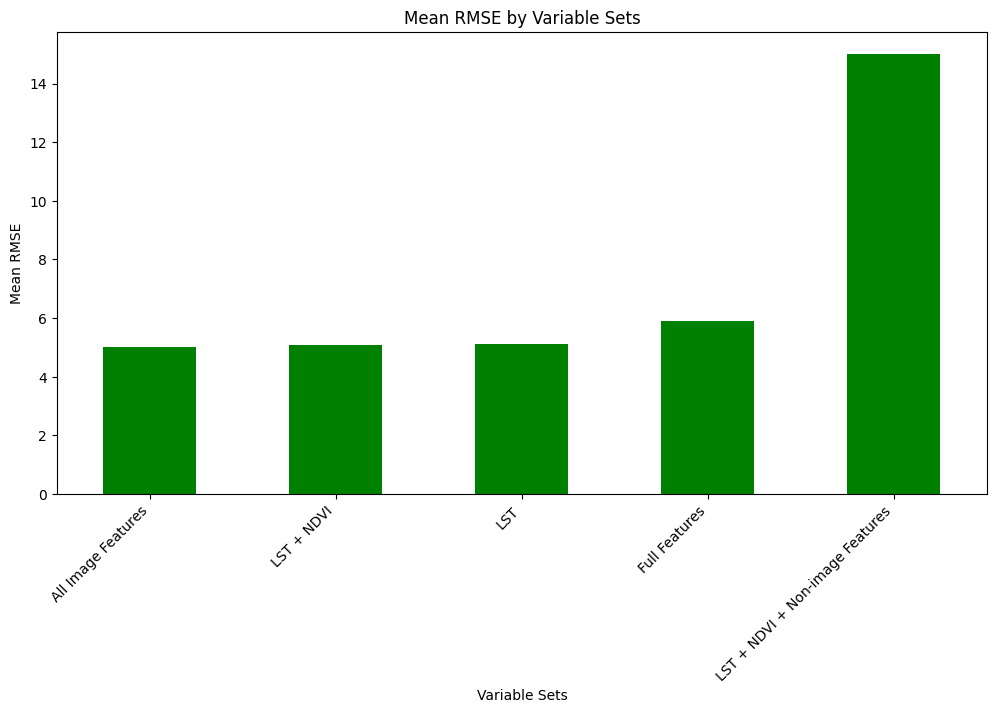

In [26]:
# Agrupar por las variables normalizadas y calcular la media del RMSE
variables_rmse = df_vars.groupby('Normalized Variables')['RMSE'].mean().sort_values()

# Plot mean RMSE for each variable set
plt.figure(figsize=(12, 6))
variables_rmse.plot(kind='bar', color='green')
plt.xlabel('Variable Sets')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE by Variable Sets')
plt.xticks(rotation=45, ha='right')
plt.show()


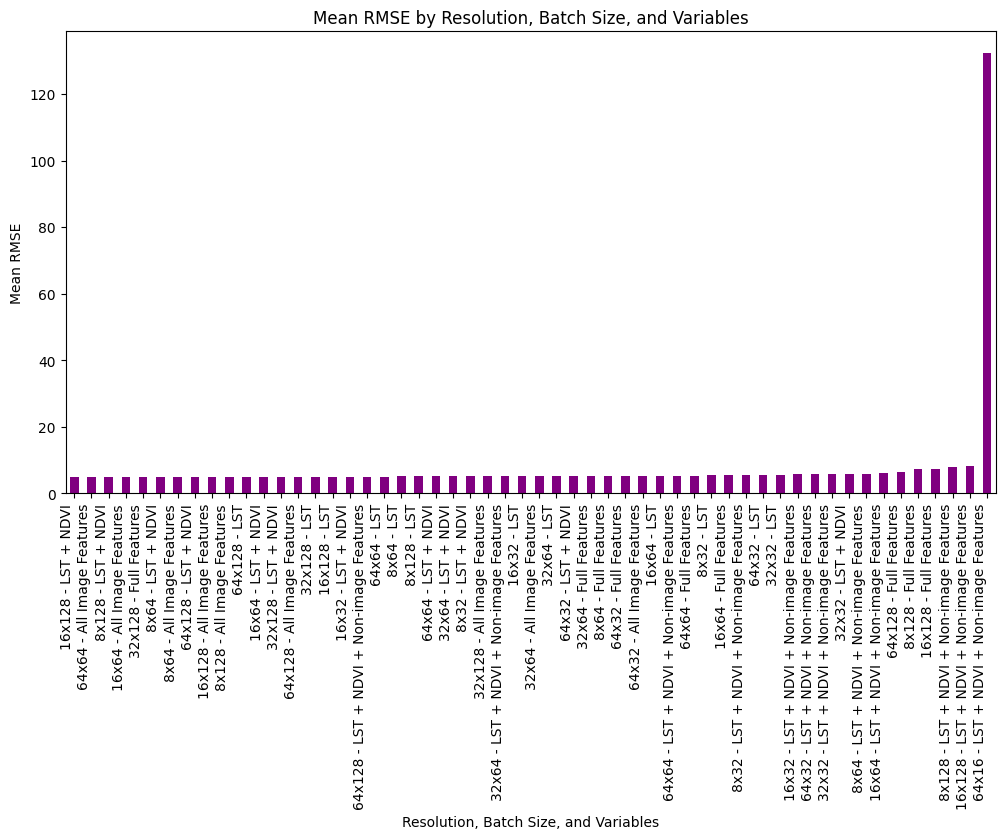

In [27]:
import matplotlib.pyplot as plt

# Crear una nueva columna combinada para Resolution, Batch Size y Variables
df['Resolution-BatchSize-Variables'] = (
    df['Resolution'].astype(str) + 'x' + df['Batch size'].astype(str) + ' - ' + df['Normalized Variables']
)

# Agrupar por la combinación y calcular la media del RMSE
combination_rmse = df.groupby('Resolution-BatchSize-Variables')['RMSE'].mean().sort_values()

# Crear el gráfico
plt.figure(figsize=(12, 6))
combination_rmse.plot(kind='bar', color='purple')
plt.xlabel('Resolution, Batch Size, and Variables')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE by Resolution, Batch Size, and Variables')
plt.xticks(rotation=90, ha='right')
plt.show()


In [28]:
# RMSE promedio por resolución
rmse_by_resolution = df.groupby('Resolution')['RMSE'].mean().sort_values()
print("RMSE by Resolution:")
print(rmse_by_resolution)

# RMSE promedio por batch size
rmse_by_batch = df.groupby('Batch size')['RMSE'].mean().sort_values()
print("\nRMSE by Batch Size:")
print(rmse_by_batch)

# RMSE promedio por variables
rmse_by_variables = df.groupby('Variables')['RMSE'].mean().sort_values()
print("\nRMSE by Variables:")
print(rmse_by_variables)

# RMSE promedio por la combinación Resolution-BatchSize-Variables
rmse_by_combination = df.groupby('Resolution-BatchSize-Variables')['RMSE'].mean().sort_values()
print("\nRMSE by Combination:")
print(rmse_by_combination)


RMSE by Resolution:
Resolution
32     5.255824
8      5.559298
16     5.562050
64    10.127870
Name: RMSE, dtype: float64

RMSE by Batch Size:
Batch size
64      5.262487
32      5.507493
128     5.522113
16     71.896118
Name: RMSE, dtype: float64

RMSE by Variables:
Variables
lst, ndvi, altitude, direction, slope                                 4.928192
lst, ndvi, slope, direction, altitude                                 5.030135
lst, ndvi, altitude, direction, slope, month, discharge, lat, lon     5.060118
lst, ndvi                                                             5.082863
lst                                                                   5.180821
lst, ndvi, slope, direction, altitude, month, discharge, lat, lon     5.647466
lst, month, discharge, lat, lon                                       7.770993
lst, ndvi, slope, altitude, direction, month, discharge, lat, lon     8.572765
lst, ndvi, month, discharge, lat, lon                                15.006198
Name: RMSE

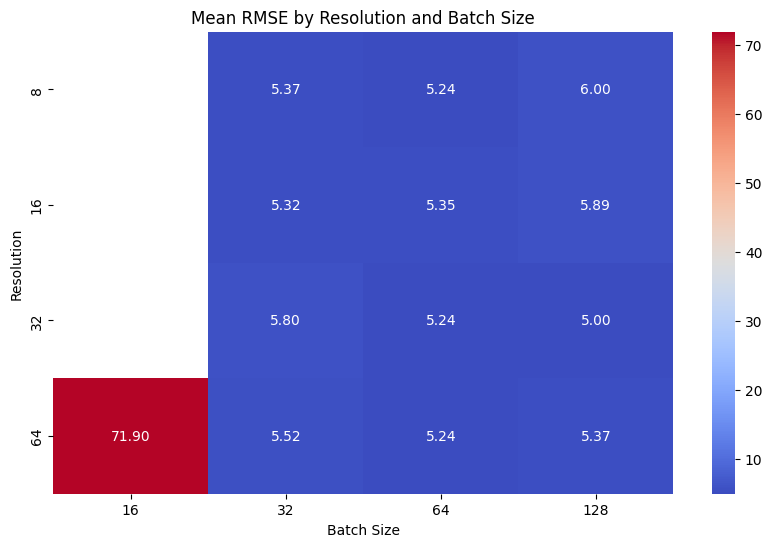

In [29]:
# RMSE promedio por resolución y batch size
rmse_res_batch = df.groupby(['Resolution', 'Batch size'])['RMSE'].mean().unstack()

# Visualizar como heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rmse_res_batch, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mean RMSE by Resolution and Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Resolution")
plt.show()


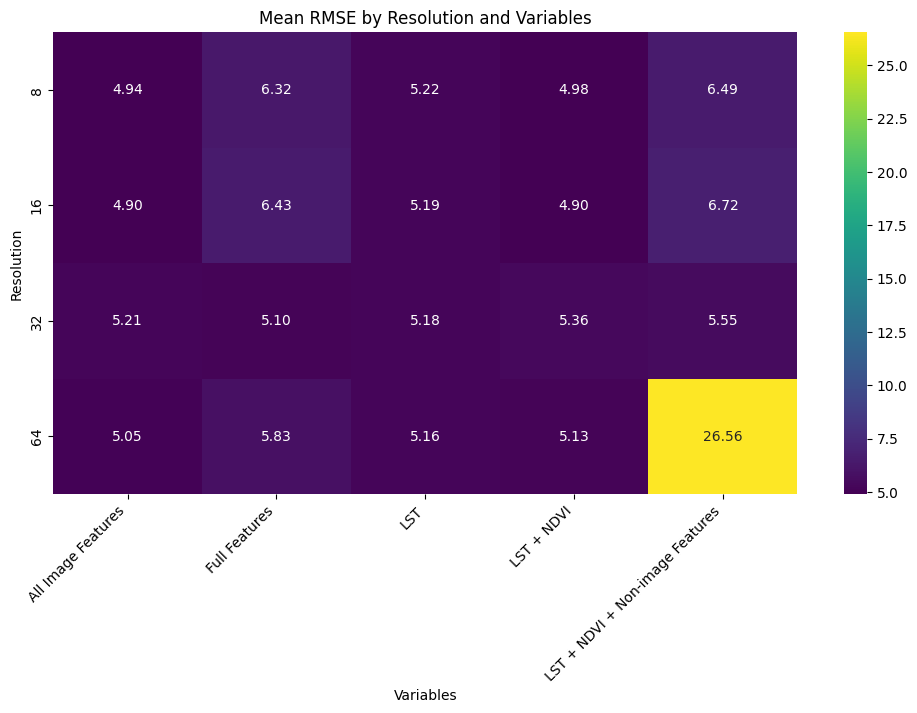

In [30]:
# RMSE promedio por resolución y variables
rmse_res_vars = df.groupby(['Resolution', 'Normalized Variables'])['RMSE'].mean().unstack()

# Visualizar como heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(rmse_res_vars, annot=True, cmap='viridis', fmt=".2f")
plt.title("Mean RMSE by Resolution and Variables")
plt.xlabel("Variables")
plt.ylabel("Resolution")
plt.xticks(rotation=45, ha='right')
plt.show()


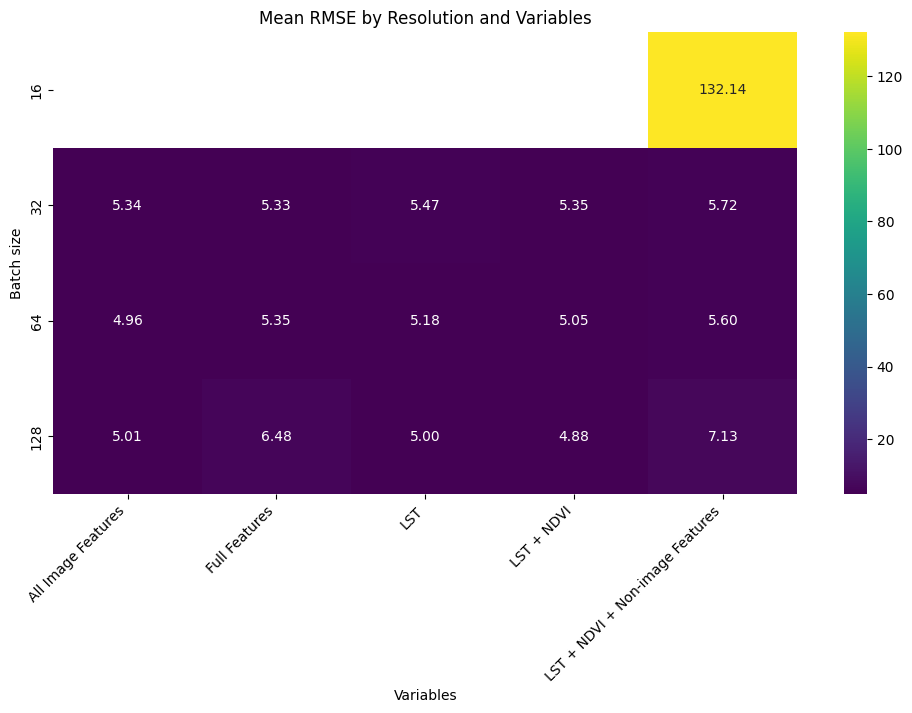

In [31]:
# RMSE promedio por resolución y variables
rmse_res_vars = df.groupby(['Batch size', 'Normalized Variables'])['RMSE'].mean().unstack()

# Visualizar como heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(rmse_res_vars, annot=True, cmap='viridis', fmt=".2f")
plt.title("Mean RMSE by Resolution and Variables")
plt.xlabel("Variables")
plt.ylabel("Batch size")
plt.xticks(rotation=45, ha='right')
plt.show()


In [32]:
df[(df['Normalized Variables']=='All Image Features')&(df.Resolution==32)&(df['Batch size']==128)]


,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables,Resolution-BatchSize-Variables
46,47,5.058354,"lst, ndvi, slope, direction, altitude",74 cells,stratified,1,Adam,1487,128,139 of 300,2024-11-20,15:55:36,276.64,RMSE,32,All Image Features,32x128 - All Image Features
47,47,5.534033,"lst, ndvi, slope, direction, altitude",74 cells,stratified,2,Adam,1487,128,167 of 300,2024-11-20,16:00:56,335.89,RMSE,32,All Image Features,32x128 - All Image Features
48,48,4.928192,"lst, ndvi, altitude, direction, slope",74 cells,stratified,3,Adam,1487,128,137 of 300,2024-11-20,16:01:00,284.80,RMSE,32,All Image Features,32x128 - All Image Features


Correlations:
            Resolution  Batch size      RMSE
Resolution    1.000000   -0.139045  0.082321
Batch size   -0.139045    1.000000 -0.108476
RMSE          0.082321   -0.108476  1.000000


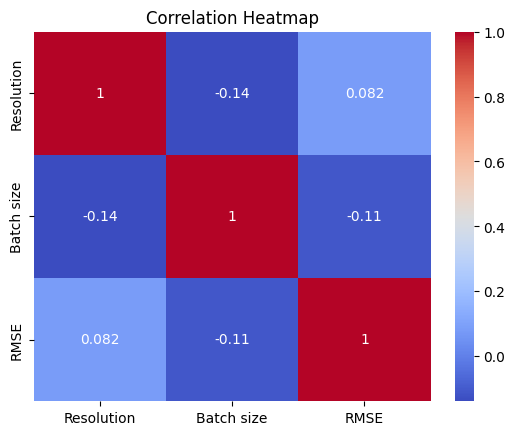

In [33]:
correlations = df[['Resolution', 'Batch size', 'RMSE']].corr()
print("Correlations:")
print(correlations)

# Heatmap de correlaciones
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


# CNN_2 analysis

In [34]:
model= 'CNN_2'
df_cnn = pd.read_excel(f'../official_results/{model}_results.xlsx')
df_cnn['Normalized Variables'] = df_cnn['Variables'].apply(
    lambda x: ', '.join(sorted(x.split(', '))))
df_cnn['Normalized Variables'] = df_cnn['Normalized Variables'].map(variable_set_mapping)
df_cnn

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
0,1,10.308114,"lst, ndvi, slope, direction, altitude, month, ...",42 cells,stratified,1,Adam,850,128,38 of 300,2024-11-22,13:37:44,59.00,RMSE,64,Full Features
1,2,8.166103,"lst, ndvi, slope, direction, altitude, month, ...",42 cells,stratified,2,Adam,850,128,36 of 300,2024-11-22,13:38:38,52.41,RMSE,64,Full Features
2,3,8.051337,"lst, ndvi, slope, direction, altitude, month, ...",42 cells,stratified,3,Adam,850,128,39 of 300,2024-11-22,13:39:38,58.98,RMSE,64,Full Features
3,3,4.928916,"lst, ndvi, altitude, direction, slope, month, ...",74 cells,stratified,1,Adam,1487,64,55 of 300,2024-11-22,13:42:37,196.52,RMSE,64,Full Features
4,4,5.037980,"lst, ndvi, altitude, direction, slope, month, ...",74 cells,stratified,2,Adam,1487,64,109 of 300,2024-11-22,13:48:49,370.03,RMSE,64,Full Features
5,5,5.055923,"lst, ndvi, altitude, direction, slope, month, ...",74 cells,stratified,3,Adam,1487,64,53 of 300,2024-11-22,13:51:52,180.21,RMSE,64,Full Features
6,3,5.031001,"lst, ndvi, altitude, direction, slope, month, ...",74 cells,stratified,1,Adam,1487,128,82 of 300,2024-11-22,13:55:05,190.05,RMSE,64,Full Features
7,4,4.710206,"lst, ndvi, altitude, direction, slope, month, ...",74 cells,stratified,2,Adam,1487,128,37 of 300,2024-11-22,13:56:35,88.02,RMSE,64,Full Features
8,5,4.744955,"lst, ndvi, altitude, direction, slope, month, ...",74 cells,stratified,3,Adam,1487,128,41 of 300,2024-11-22,13:58:15,97.38,RMSE,64,Full Features
9,10,4.982225,"lst, ndvi, altitude, slope, direction",74 cells + augmented,stratified,1,Adam,1487,128,76 of 300,2024-11-25,13:49:16,242.87,RMSE,64,All Image Features


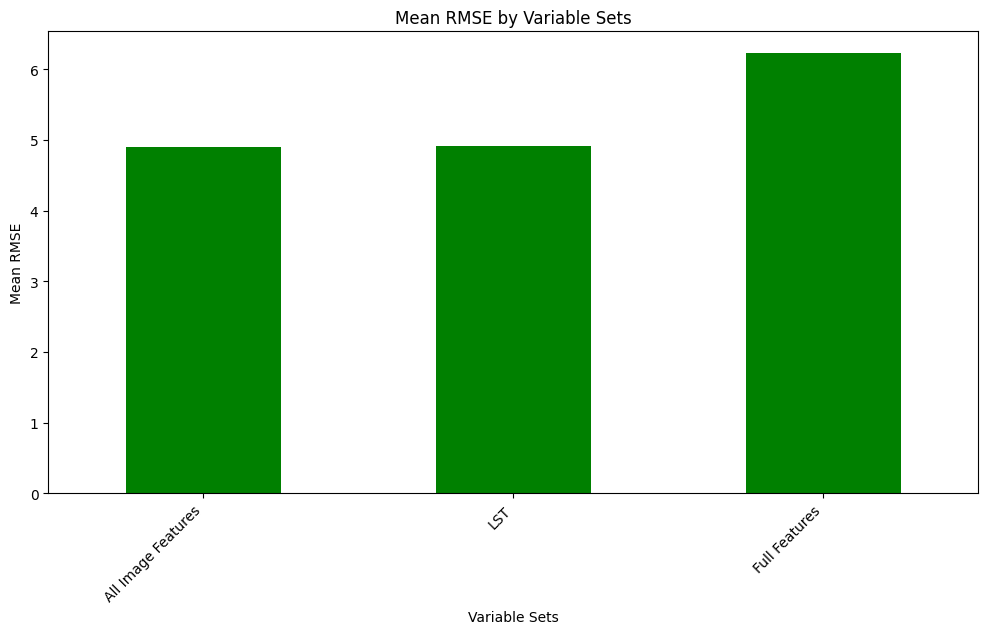

In [35]:
# Agrupar por las variables normalizadas y calcular la media del RMSE
variables_rmse = df_cnn.groupby('Normalized Variables')['RMSE'].mean().sort_values()

# Plot mean RMSE for each variable set
plt.figure(figsize=(12, 6))
variables_rmse.plot(kind='bar', color='green')
plt.xlabel('Variable Sets')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE by Variable Sets')
plt.xticks(rotation=45, ha='right')
plt.show()


In [36]:
grouping_columns = [col for col in df_cnn.columns if col not in ['Date','Split_id', 'RMSE','Duration','Time','Experiment','Epochs','Variables']]

experiment_mean_rmse = df_cnn.groupby(grouping_columns)['RMSE'].mean().reset_index()
print('Best experiment combination:')
print(experiment_mean_rmse.loc[experiment_mean_rmse['RMSE'].idxmin()])
print('\nFull experiments combination:', len(experiment_mean_rmse))
experiment_mean_rmse.sort_values("RMSE").head(10)

Best experiment combination:
Input                        74 cells
Split                      stratified
Optimizer                        Adam
nº samples                       1487
Batch size                        128
Loss                             RMSE
Resolution                         64
Normalized Variables    Full Features
RMSE                         4.828721
Name: 2, dtype: object

Full experiments combination: 6


,Input,Split,Optimizer,nº samples,Batch size,Loss,Resolution,Normalized Variables,RMSE
2,74 cells,stratified,Adam,1487,128,RMSE,64,Full Features,4.828721
5,74 cells + augmented,stratified,Adam,1487,128,RMSE,64,LST,4.897231
4,74 cells + augmented,stratified,Adam,1487,128,RMSE,64,All Image Features,4.905879
3,74 cells + augmented,stratified,Adam,1487,64,RMSE,64,LST,4.941541
1,74 cells,stratified,Adam,1487,64,RMSE,64,Full Features,5.007607
0,42 cells,stratified,Adam,850,128,RMSE,64,Full Features,8.841851


# Resnet analysis

In [37]:
model= 'Resnet'
df_resnet = pd.read_excel(f'../official_results/{model}_results.xlsx')
df_resnet['Normalized Variables'] = df_resnet['Variables'].apply(
    lambda x: ', '.join(sorted(x.split(', '))))
df_resnet['Normalized Variables'] = df_resnet['Normalized Variables'].map(variable_set_mapping)
df_resnet 

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
0,1,4.713529,"lst, ndvi, slope, direction, altitude, month, ...",74 cells,stratified,1,Adam,1487,128,56 of 300,2024-11-22,13:58:40,258.65,RMSE,64,Full Features
1,2,4.897418,"lst, ndvi, slope, direction, altitude, month, ...",74 cells,stratified,2,Adam,1487,128,65 of 300,2024-11-22,14:03:39,296.52,RMSE,64,Full Features
2,3,4.762808,"lst, ndvi, slope, direction, altitude, month, ...",74 cells,stratified,3,Adam,1487,128,67 of 300,2024-11-22,14:08:47,305.53,RMSE,64,Full Features
3,4,4.982928,"lst, ndvi, altitude, slope, direction, month, ...",74 cells,stratified,1,Adam,1487,64,39 of 300,2024-11-25,11:03:08,319.75,RMSE,64,Full Features
4,4,5.074360,"lst, ndvi, month, discharge, lat, lon",74 cells,stratified,1,Adam,1487,64,67 of 300,2024-11-25,11:09:02,531.77,RMSE,64,LST + NDVI + Non-image Features
5,5,5.263395,"lst, ndvi, month, discharge, lat, lon",74 cells,stratified,2,Adam,1487,64,38 of 300,2024-11-25,11:14:04,299.16,RMSE,64,LST + NDVI + Non-image Features
6,4,4.704808,"lst, ndvi, slope, altitude, direction",74 cells,stratified,1,Adam,1487,64,103 of 300,2024-11-25,11:14:16,766.55,RMSE,64,All Image Features
7,5,4.891346,"lst, ndvi, altitude, slope, direction, month, ...",74 cells,stratified,2,Adam,1487,64,85 of 300,2024-11-25,11:14:54,703.64,RMSE,64,Full Features
8,6,4.728972,"lst, ndvi, month, discharge, lat, lon",74 cells,stratified,3,Adam,1487,64,51 of 300,2024-11-25,11:20:49,402.86,RMSE,64,LST + NDVI + Non-image Features
9,6,4.941787,"lst, ndvi, altitude, slope, direction, month, ...",74 cells,stratified,3,Adam,1487,64,75 of 300,2024-11-25,11:25:19,621.48,RMSE,64,Full Features


In [38]:
df_resnet[df_resnet.RMSE == df_resnet['RMSE'].min()]

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
27,28,4.641574,lst,74 cells + augmented,stratified,1,Adam,1487,128,300 of 300,2024-11-26,11:40:35,2233.22,RMSE,64,LST


In [39]:
grouping_columns = [col for col in df_resnet.columns if col not in ['Date','Split_id', 'RMSE','Duration','Time','Experiment','Epochs','Variables']]

experiment_mean_rmse = df_resnet.groupby(grouping_columns)['RMSE'].mean().reset_index()
print('Best experiment combination:')
print(experiment_mean_rmse.loc[experiment_mean_rmse['RMSE'].idxmin()])
print('\nFull experiments combination:', len(experiment_mean_rmse))
experiment_mean_rmse.sort_values("RMSE").head(10)

Best experiment combination:
Input                   74 cells + augmented
Split                             stratified
Optimizer                               Adam
nº samples                              1487
Batch size                               128
Loss                                    RMSE
Resolution                                64
Normalized Variables                     LST
RMSE                                4.784566
Name: 9, dtype: object

Full experiments combination: 10


,Input,Split,Optimizer,nº samples,Batch size,Loss,Resolution,Normalized Variables,RMSE
9,74 cells + augmented,stratified,Adam,1487,128,RMSE,64,LST,4.784566
5,74 cells,stratified,Adam,1487,128,RMSE,64,Full Features,4.791251
7,74 cells,stratified,Adam,1487,128,RMSE,64,LST + NDVI + Non-image Features,4.793546
0,74 cells,stratified,Adam,1487,64,RMSE,64,All Image Features,4.799205
4,74 cells,stratified,Adam,1487,128,RMSE,64,All Image Features,4.806338
6,74 cells,stratified,Adam,1487,128,RMSE,64,LST + NDVI,4.810439
2,74 cells,stratified,Adam,1487,64,RMSE,64,LST + NDVI,4.834513
8,74 cells + augmented,stratified,Adam,1487,128,RMSE,64,All Image Features,4.836274
1,74 cells,stratified,Adam,1487,64,RMSE,64,Full Features,4.938687
3,74 cells,stratified,Adam,1487,64,RMSE,64,LST + NDVI + Non-image Features,5.022242


## Pretrained

In [40]:
model= 'transfer_resnet'
df_pr_resnet = pd.read_excel(f'../official_results/{model}_results.xlsx')
df_pr_resnet['Normalized Variables'] = df_pr_resnet['Variables'].apply(
    lambda x: ', '.join(sorted(x.split(', '))))
df_pr_resnet['Normalized Variables'] = df_pr_resnet['Normalized Variables'].map(variable_set_mapping)
df_pr_resnet

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
0,1,4.724000,lst,74 cells + augmented,stratified,1,Adam,1487,128,56 of 300,2024-11-25,15:27:53,173.74,RMSE,64,LST
1,2,4.895312,lst,74 cells + augmented,stratified,2,Adam,1487,128,45 of 300,2024-11-25,15:30:15,139.65,RMSE,64,LST
2,3,4.791817,lst,74 cells + augmented,stratified,3,Adam,1487,128,42 of 300,2024-11-25,15:32:29,130.83,RMSE,64,LST
3,4,4.850090,"lst, ndvi",74 cells + augmented,stratified,1,Adam,1487,128,31 of 300,2024-11-25,15:35:25,103.05,RMSE,64,LST + NDVI
4,5,5.392570,"lst, ndvi",74 cells + augmented,stratified,2,Adam,1487,128,31 of 300,2024-11-25,15:37:08,99.91,RMSE,64,LST + NDVI
5,6,4.948735,"lst, ndvi",74 cells + augmented,stratified,3,Adam,1487,128,31 of 300,2024-11-25,15:38:53,102.38,RMSE,64,LST + NDVI
6,7,4.762301,"lst, ndvi",74 cells + augmented,stratified,1,Adam,1487,128,300 of 300,2024-11-25,15:57:16,912.94,RMSE,64,LST + NDVI
7,7,4.691038,"lst, ndvi",74 cells + augmented,stratified,1,Adam,1487,128,300 of 300,2024-11-25,16:03:35,941.16,RMSE,64,LST + NDVI
8,8,4.930842,"lst, ndvi",74 cells + augmented,stratified,2,Adam,1487,128,300 of 300,2024-11-25,16:12:44,924.72,RMSE,64,LST + NDVI
9,8,4.951113,"lst, ndvi",74 cells + augmented,stratified,2,Adam,1487,128,300 of 300,2024-11-25,16:19:15,936.67,RMSE,64,LST + NDVI


In [41]:
grouping_columns = [col for col in df_pr_resnet.columns if col not in ['Date','Split_id', 'RMSE','Duration','Time','Experiment','Epochs','Variables']]

experiment_mean_rmse = df_pr_resnet.groupby(grouping_columns)['RMSE'].mean().reset_index()
print('Best experiment combination:')
print(experiment_mean_rmse.loc[experiment_mean_rmse['RMSE'].idxmin()])
print('\nFull experiments combination:', len(experiment_mean_rmse))
experiment_mean_rmse.sort_values("RMSE").head(10)

Best experiment combination:
Input                   74 cells + augmented
Split                             stratified
Optimizer                               Adam
nº samples                              1487
Batch size                               128
Loss                                    RMSE
Resolution                                64
Normalized Variables                     LST
RMSE                                 4.80371
Name: 0, dtype: object

Full experiments combination: 2


,Input,Split,Optimizer,nº samples,Batch size,Loss,Resolution,Normalized Variables,RMSE
0,74 cells + augmented,stratified,Adam,1487,128,RMSE,64,LST,4.803710
1,74 cells + augmented,stratified,Adam,1487,128,RMSE,64,LST + NDVI,4.909742


# Model comparison

## LST only

In [42]:
# Filter dataframes for both input types
dfs = []
for dff in [df, df_cnn, df_resnet, df_pr_resnet]:
    df_filt = dff[
        (dff['Normalized Variables'] == 'LST') & 
        (dff['Batch size'] == 128) & 
        (dff.Resolution == 64) & 
        (dff.Loss == 'RMSE') & 
        (dff.Input == '74 cells + augmented') &
        (dff.Optimizer == 'Adam')
    ]
    dfs.append(df_filt)
    print(df_filt.shape)

rmse_values = []
for i in range(len(dfs)):
    a_df = dfs[i]
    
    rmse_values.append(
        a_df['RMSE'].mean())


(3, 17)
(3, 16)
(3, 16)
(3, 16)


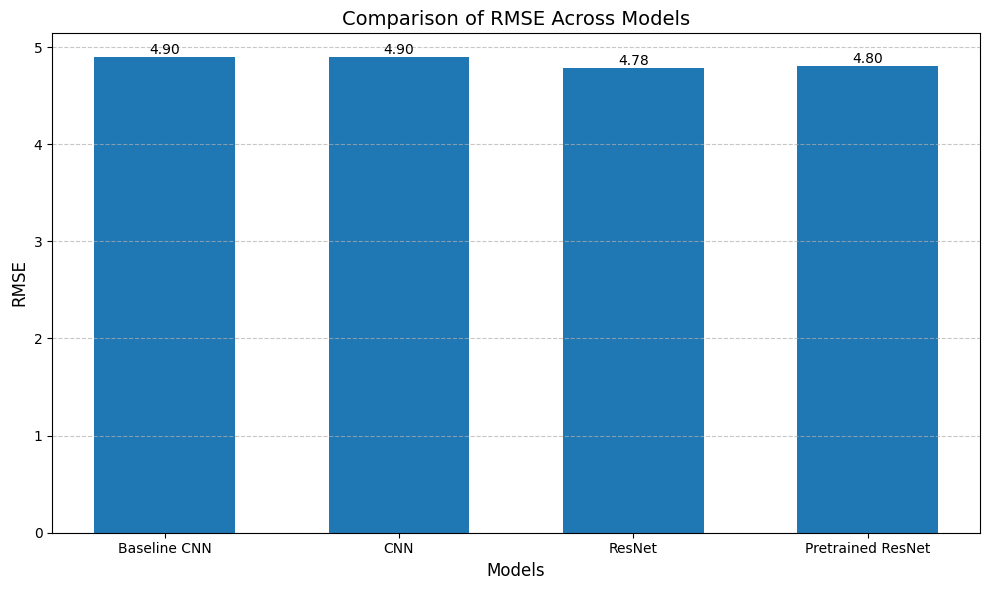

In [43]:
# Model names
model_names = ['Baseline CNN', 'CNN', 'ResNet', 'Pretrained ResNet']

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, rmse_values, width=0.6)

# Annotate each bar with its RMSE value
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height(), 
        f"{bar.get_height():.2f}", 
        ha='center', 
        va='bottom', 
        fontsize=10
    )

# Add labels, title, and grid
plt.xlabel("Models", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("Comparison of RMSE Across Models", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


## Full features

In [44]:
# Filter dataframes for both input types
augmented_dfs = []
non_augmented_dfs = []
for dff in [df, df_cnn, df_resnet, df_pr_resnet]:
    df_filt_augmented = dff[
        (dff['Normalized Variables'] == 'Full Features') & 
        (dff['Batch size'] == 128) & 
        (dff.Resolution == 64) & 
        (dff.Loss == 'RMSE') & 
        (dff.Input == '74 cells + augmented')
    ]
    augmented_dfs.append(df_filt_augmented)
    
    df_filt_non_augmented = dff[
        (dff['Normalized Variables'] == 'Full Features') & 
        (dff['Batch size'] == 128) & 
        (dff.Resolution == 64) & 
        (dff.Loss == 'RMSE') & 
        (dff.Input == '74 cells')
    ]
    non_augmented_dfs.append(df_filt_non_augmented)
    print(df_filt_augmented.shape, df_filt_non_augmented.shape)

rmse_values_augmented = []
rmse_values_non_augmented = []
for i in range(len(augmented_dfs)):
    a_df = augmented_dfs[i]
    na_df = non_augmented_dfs[i]
    
    rmse_values_augmented.append(
        a_df['RMSE'].mean())

    rmse_values_non_augmented.append(
        na_df['RMSE'].mean())


(0, 17) (4, 17)
(0, 16) (3, 16)
(0, 16) (3, 16)
(0, 16) (0, 16)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


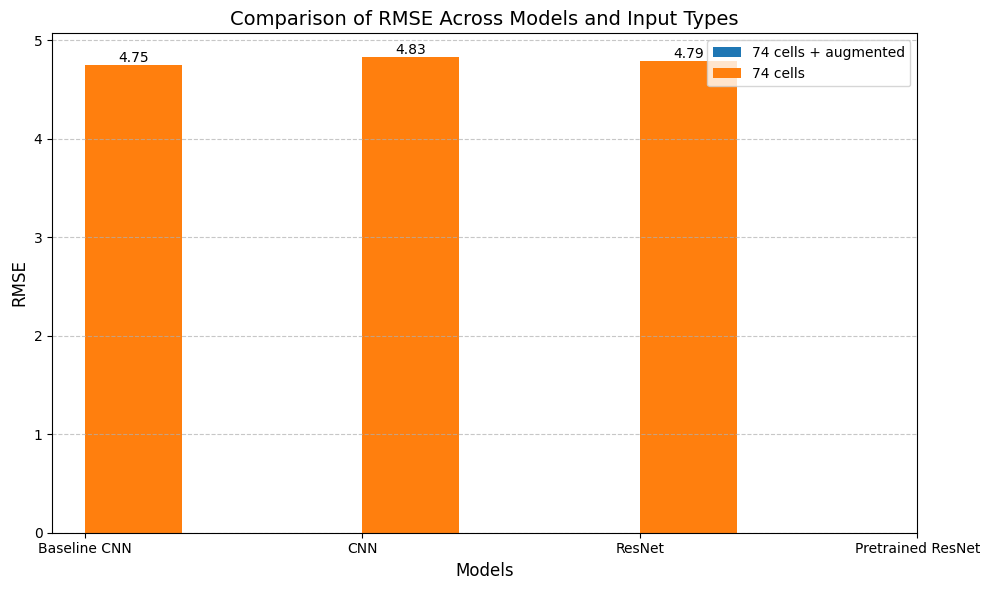

In [45]:
# Define parameters for the plot
x = range(len(model_names))  # X positions for the models
width = 0.35  # Width of the bars

# Create the bar plot with annotations for each bar
plt.figure(figsize=(10, 6))

# Plot for augmented input
bar_positions_augmented = [pos - width/2 for pos in x]
bars_augmented = plt.bar(
    bar_positions_augmented, 
    rmse_values_augmented, 
    width=width, 
    label='74 cells + augmented'
)

# Plot for non-augmented input
bar_positions_non_augmented = [pos + width/2 for pos in x]
bars_non_augmented = plt.bar(
    bar_positions_non_augmented, 
    rmse_values_non_augmented, 
    width=width, 
    label='74 cells'
)

# Annotate each bar with its RMSE value
for bar in bars_augmented:
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height(), 
        f"{bar.get_height():.2f}", 
        ha='center', 
        va='bottom', 
        fontsize=10
    )

for bar in bars_non_augmented:
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height(), 
        f"{bar.get_height():.2f}", 
        ha='center', 
        va='bottom', 
        fontsize=10
    )

# Add labels, title, and legend
plt.xlabel("Models", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("Comparison of RMSE Across Models and Input Types", fontsize=14)
plt.xticks(x, model_names, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


## LST + NDVI

In [46]:
# Filter dataframes for both input types
augmented_dfs = []
non_augmented_dfs = []
for dff in [df, df_cnn, df_resnet, df_pr_resnet]:
    df_filt_augmented = dff[
        (dff['Normalized Variables'] == 'LST + NDVI') & 
        (dff['Batch size'] == 128) & 
        (dff.Resolution == 64) & 
        (dff.Loss == 'RMSE') & 
        (dff.Input == '74 cells + augmented')
    ]
    augmented_dfs.append(df_filt_augmented)
    
    df_filt_non_augmented = dff[
        (dff['Normalized Variables'] == 'LST + NDVI') & 
        (dff['Batch size'] == 128) & 
        (dff.Resolution == 64) & 
        (dff.Loss == 'RMSE') & 
        (dff.Input == '74 cells')
    ]
    non_augmented_dfs.append(df_filt_non_augmented)
    print(df_filt_augmented.shape, df_filt_non_augmented.shape)

rmse_values_augmented = []
rmse_values_non_augmented = []
for i in range(len(augmented_dfs)):
    a_df = augmented_dfs[i]
    na_df = non_augmented_dfs[i]
    
    rmse_values_augmented.append(
        a_df['RMSE'].mean())

    rmse_values_non_augmented.append(
        na_df['RMSE'].mean())


(0, 17) (3, 17)
(0, 16) (0, 16)
(0, 16) (3, 16)
(9, 16) (0, 16)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


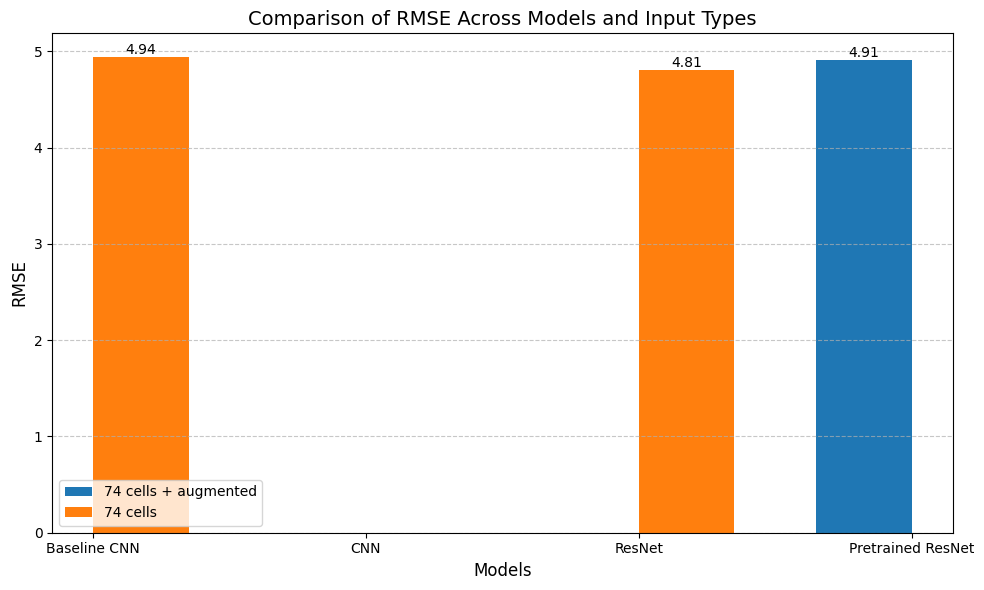

In [47]:
# Define parameters for the plot
x = range(len(model_names))  # X positions for the models
width = 0.35  # Width of the bars

# Create the bar plot with annotations for each bar
plt.figure(figsize=(10, 6))

# Plot for augmented input
bar_positions_augmented = [pos - width/2 for pos in x]
bars_augmented = plt.bar(
    bar_positions_augmented, 
    rmse_values_augmented, 
    width=width, 
    label='74 cells + augmented'
)

# Plot for non-augmented input
bar_positions_non_augmented = [pos + width/2 for pos in x]
bars_non_augmented = plt.bar(
    bar_positions_non_augmented, 
    rmse_values_non_augmented, 
    width=width, 
    label='74 cells'
)

# Annotate each bar with its RMSE value
for bar in bars_augmented:
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height(), 
        f"{bar.get_height():.2f}", 
        ha='center', 
        va='bottom', 
        fontsize=10
    )

for bar in bars_non_augmented:
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height(), 
        f"{bar.get_height():.2f}", 
        ha='center', 
        va='bottom', 
        fontsize=10
    )

# Add labels, title, and legend
plt.xlabel("Models", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("Comparison of RMSE Across Models and Input Types", fontsize=14)
plt.xticks(x, model_names, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
